In [1]:
from PIL import Image
import numpy as np
import scipy.signal
import cv2

In [2]:
class Environment:
    def __init__(self, shape=(100,100), tree_density=0.55, random_seed=None):

        self._shape = shape
        self._tree_density = tree_density
        self._seed = random_seed
        
        # make state map where:
        # 0 - intact
        # 1 - on fire
        self._state_map = np.zeros(shape, dtype=np.uint8)

        # set center on fire
        self.ignite_center() 
        
        # make fuel map
        self._fuel_map = self.generate_fuel_map(shape, tree_density, random_seed)
        
        # history object
        self._history = {
            'states': [],
            'fuel_maps': [],
            'new_ignitions': []
        }
        
    @staticmethod
    def generate_fuel_map(shape=(100,100), tree_density=0.55, random_seed=None):
        # fuel array corresponding to the ammount of fuel in each cell (0-255)
        fuel_map = np.zeros(shape, dtype=np.uint8)

        # how many trees to generate. E.g. tree_density=0.55 on a (100,100) lattice gives us 0.55*100*100 = 5500 trees
        tree_count = int(shape[0]*shape[1] * tree_density)

        if random_seed:
            # reproducibility
            np.random.seed(random_seed) 

        # Generate 5500 (x,y) locations of trees
        tree_locs = np.random.randint(low=0,
                                      high=(shape[0], shape[1]),
                                      size=(tree_count, 2)
                                     ) 

        fuel_map[tree_locs[:,0], tree_locs[:,1]] = np.random.randint(0,255,tree_count)
        
        return fuel_map
    
    def ignite_center(self):
        center_x = int(self._state_map.shape[0]/2)
        center_y = int(self._state_map.shape[1]/2)
        self._state_map[center_x-3:center_x+3,center_y-3:center_y+3] = 1
    
    @staticmethod
    def ignition_kernel():
        kernel3by3 = np.array([[1,1,1],[1,0,1],[1,1,1]]) # 3x3
        return kernel3by3
    
    def step(self, burn_rate=3, ignition_prob=0.2):
        
        # assign to local variables
        state = self._state_map
        fuel = self._fuel_map
        
        # calculate new ignitons
        kernel = self.ignition_kernel()
        count_neighbors_on_fire = scipy.signal.convolve2d(state, kernel, 'same')
        ignitions = (count_neighbors_on_fire * np.random.random(state.shape) > ignition_prob) * fuel
        state += ignitions
        
        #update fuel status
        on_fire_mask = state > 0
        burned_out_mask = fuel < burn_rate
        fuel[on_fire_mask] -= burn_rate 
        fuel[burned_out_mask] = 0
        state[burned_out_mask] = 0

        # update histories
        # ignitions_history[i] = ignitions
        # states_history[i] = state
        # fuel_history[i] = fuel

    def reset():
        self._state_map = np.zeros(shape, dtype=np.uint8)
        self.ignite_center() 
        
        # make fuel map
        self._fuel_map = self.generate_fuel_map()

    def snapshot(self):
        # gets a snapshot of the state
        
        red = self._state_map.copy()
        red[red>0] = 255 # make fire cells max intensity
        
        green = self._fuel_map.copy()
        green[red>0] = 0

        # if we need to resize
        red = cv2.resize(red, (500,500), interpolation=cv2.INTER_NEAREST)
        green = cv2.resize(green, (500,500), interpolation=cv2.INTER_NEAREST)

        blue = np.zeros_like(green)
        im = np.stack([red, green, blue], axis=-1)

        return Image.fromarray(im)
    
    def fire(self):
        red = self._state_map.copy()
        red[red>0] = 255
        red = cv2.resize(red, (500,500), interpolation=cv2.INTER_NEAREST)
        
        green = np.zeros_like(red)
        blue = np.zeros_like(red)
        
        im = np.stack([red, green, blue], axis=-1)
        return Image.fromarray(im)
    
    
    def fuel(self):
        green = self._fuel_map.copy()
        green = cv2.resize(green, (500,500), interpolation=cv2.INTER_NEAREST)
        
        red = np.zeros_like(green)
        blue = np.zeros_like(green)
        
        im = np.stack([red, green, blue], axis=-1)
        return Image.fromarray(im)
    
    @staticmethod
    def gkern(l=5, sig=1.):
        """
        creates gaussian kernel with side length l and a sigma of sig
        """

        ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
        xx, yy = np.meshgrid(ax, ax)

        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

        return kernel / np.sum(kernel)



In [3]:
env = Environment(shape=(300,300))
env._state_map.sum()

36

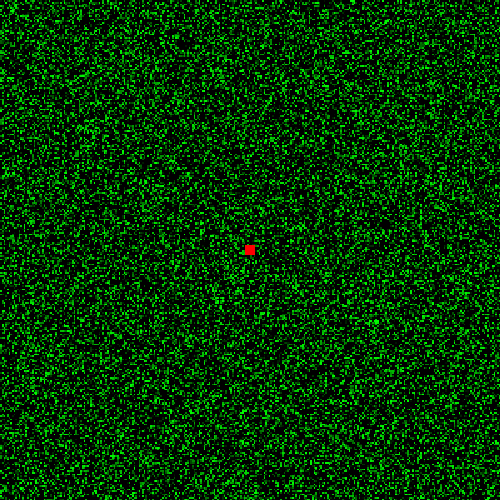

In [4]:
env.snapshot()

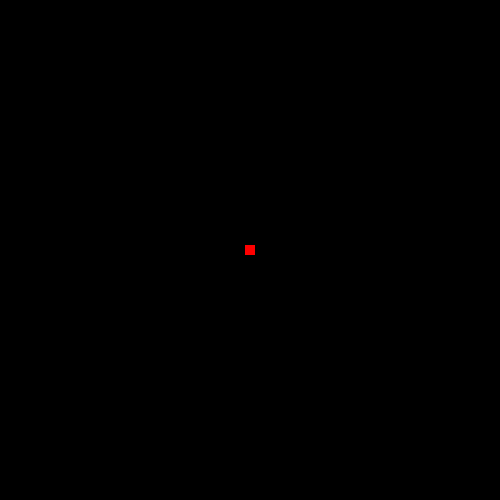

In [5]:
env.fire()

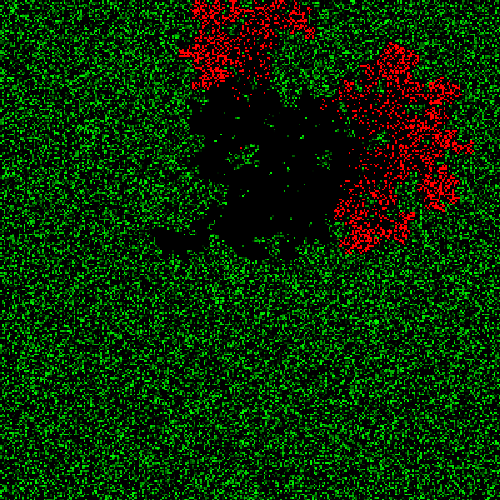

In [6]:
for _ in range(200):
    env.step()
env.snapshot()

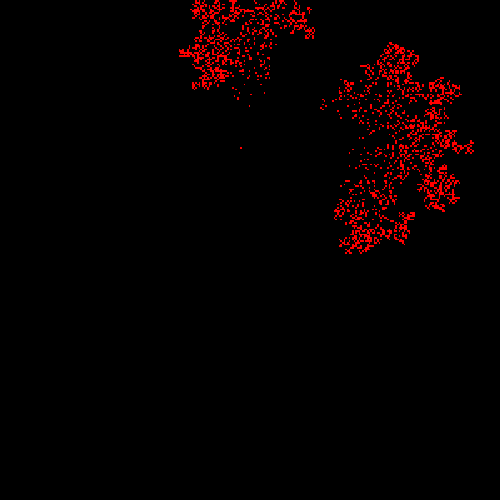

In [7]:
env.fire()

In [8]:
%timeit env.step()

4.75 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
